In [1]:
# Importing Required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)# To see all the columns of a dataframe
#pd.set_option('display.max_rows', None)

In [2]:
# Function to reduce the memory usage of various Dataframes
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
       
        1. Iterate over every column
        2. Determine if the column is numeric
        3. Determine if the column can be represented by an integer
        4. Find the min and the max value
        5. Determine and apply the smallest datatype that can fit the range of values

    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [3]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
# Loading reduced feature training set
X_train = import_data('X_train_final.csv')
y_train = pd.read_csv('y_train.final.csv')

Memory usage of dataframe is 181.24 MB
Memory usage after optimization is: 38.27 MB
Decreased by 78.9%


In [5]:
# Loading reduced feature test set
X_test = import_data('X_test_final.csv')
y_test = pd.read_csv('y_test.final.csv')

Memory usage of dataframe is 60.41 MB
Memory usage after optimization is: 12.76 MB
Decreased by 78.9%


 ## Model_6: Random Forest Classifier with Tuned Hyperparameters using RandomSearch CV.

In [6]:
# Importing the Sklearn's roc_auc_score module
from sklearn.metrics import roc_auc_score

In [7]:
# Importing required Libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [8]:
# Instantiating the Stratified K fold object
cv_strat = StratifiedKFold(5,random_state=42)

In [9]:
# Importing Random Forest Classifier from  Sklearn
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Instantiating the Random forest classifier
rf_s = RandomForestClassifier(n_jobs=5, random_state=42)

In [11]:
# Importing Randomized search CV object
from sklearn.model_selection import RandomizedSearchCV

In [13]:
# defining Class weights
cl_weight = [None,'balanced',{0:1.0,1:12},{0:1.0,1:13},{0:1.0,1:14},{0:1.0,1:15},{0:1.0,1:16},
            {0:1.0,1:17}]

In [14]:
# Defining hyper-parameter space for the Random forest classifier 
params = {'max_depth':list(range(2,60)) + [None],'n_estimators':np.arange(100,1500,10),
         'class_weight':cl_weight,'min_samples_leaf':[.00001,.0001,.001,.01,.05,.1]}


In [15]:
# Defining Randomized Search CV object
rand_cv = RandomizedSearchCV(rf_s, param_distributions=params, scoring='roc_auc', n_jobs=5,
                                  cv=cv_strat, random_state=42, n_iter=50, return_train_score=True)

In [16]:
# Fitting the randomized search CV object on the Training set.
rand_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=5, random_state=42),
                   n_iter=50, n_jobs=5,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         {0: 1.0, 1: 12},
                                                         {0: 1.0, 1: 13},
                                                         {0: 1.0, 1: 14},
                                                         {0: 1.0, 1: 15},
                                                         {0: 1.0, 1: 16},
                                                         {0: 1.0, 1: 17}],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 2...
        870,  880,  890,  900,  910,  920,  93

In [17]:
# Getting the the best hyper parameters of the Random Tree Classifier from Random Search CV study
rand_cv.best_params_

{'n_estimators': 1480,
 'min_samples_leaf': 1e-05,
 'max_depth': 47,
 'class_weight': 'balanced'}

In [18]:
# Getting the study's best roc_auc score
rand_cv.best_score_

0.7534642534966448

In [19]:
# Defining the function to calculate the roc_auc score for the feature sets
def cal_roc_auc(X, y, cls, f_set, t_set, model_name):
    ''' Calculates the roc auc score using the best study parameters 
        f_set : String: specifies 'full feature', 'Reduced feature'
        t_set: String: specifies 'training', 'test'
        model_name: String: specifies Name of the model '''
        
    y_pred = cls.predict_proba(X)
    print('The roc_auc_score for the {} {} set using the best {} is '.format(f_set,t_set,model_name),roc_auc_score(y,y_pred[:,1]))

In [20]:
# Calculating the Reduced feature training set roc_auc score using the best study parameters
cal_roc_auc(X_train, y_train, rand_cv, 'Reduced feature', 'training', 'Random Forest Classifier')

The roc_auc_score for the Reduced feature training set using the best Random Forest Classifier is  1.0


In [21]:
# Calculating the Reduced feature test set roc_auc score using the best study parameters
cal_roc_auc(X_test, y_test, rand_cv, 'Reduced feature', 'test', 'Random Forest Classifier')

The roc_auc_score for the Reduced feature test set using the best Random Forest Classifier is  0.7592636813381282


In [56]:
# Saving the best RF model tuned via Random seach CV
import joblib
rf_rand = rand_cv.best_estimator_
joblib.dump(rf_rand,'Rand_Forest_rand_search.joblib')

['Rand_Forest_rand_search.joblib']

In [23]:
# Converting the RandomSearch CV study Results Dictionary to a Dataframe
CV_Results = pd.DataFrame(rand_cv.cv_results_)

In [57]:
# Saving the CV_Results dataframe as a csv file
CV_Results.to_csv('Rand_Search_CV_Results.csv',index=False)

In [24]:
# Viewing the head of the resulting dataframe
CV_Results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_depth,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,127.992223,0.776854,1.674527,0.126046,280,0.0001,29,"{0: 1.0, 1: 12}","{'n_estimators': 280, 'min_samples_leaf': 0.00...",0.747507,0.748006,0.758541,0.754960,0.752441,0.752291,0.004182,5,0.980862,0.981005,0.981795,0.981210,0.981380,0.981250,0.000324
1,15.450197,0.465961,0.661445,0.253451,170,0.1,58,"{0: 1.0, 1: 12}","{'n_estimators': 170, 'min_samples_leaf': 0.1,...",0.702065,0.702113,0.714198,0.708996,0.708642,0.707203,0.004616,41,0.710482,0.709662,0.708248,0.708989,0.709461,0.709368,0.000740
2,323.150645,0.879732,5.273709,0.171163,620,1e-05,41,"{0: 1.0, 1: 12}","{'n_estimators': 620, 'min_samples_leaf': 1e-0...",0.747424,0.745974,0.757263,0.754105,0.749652,0.750884,0.004211,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,63.166241,0.235521,1.071533,0.284719,280,0.01,24,"{0: 1.0, 1: 17}","{'n_estimators': 280, 'min_samples_leaf': 0.01...",0.725403,0.726305,0.736997,0.733205,0.731884,0.730759,0.004352,32,0.742724,0.742477,0.740338,0.742173,0.741362,0.741815,0.000869
4,108.367339,0.519226,1.509065,0.367437,480,0.01,15,"{0: 1.0, 1: 15}","{'n_estimators': 480, 'min_samples_leaf': 0.01...",0.726365,0.726636,0.737058,0.733833,0.732051,0.731189,0.004152,29,0.743204,0.742920,0.740760,0.742614,0.741517,0.742203,0.000920


In [25]:
# Sorting the CV_Results dataframe by the Test score Rank
CV_Results = CV_Results.sort_values(by=['rank_test_score'])

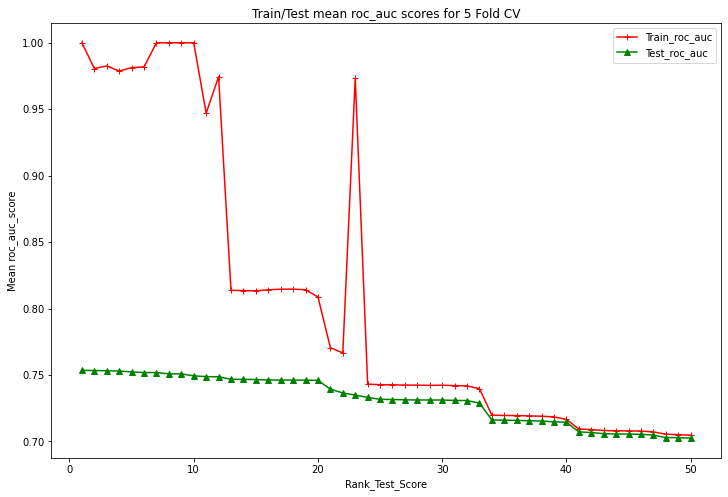

In [27]:
# Plotting the mean Training & mean Test 5 fold roc_auc scores for the training dataset vs rank_test_score 
# obtained from Random Search CV.
plt.figure(figsize=(12,8))
plt.plot('rank_test_score', 'mean_train_score', data=CV_Results, label='Train_roc_auc', marker='+', color='r')
plt.plot('rank_test_score', 'mean_test_score', data=CV_Results, label='Test_roc_auc', marker='^',color='g')
plt.legend()
plt.title('Train/Test mean roc_auc scores for 5 Fold CV')
plt.xlabel('Rank_Test_Score')
plt.ylabel('Mean roc_auc_score')
plt.show()

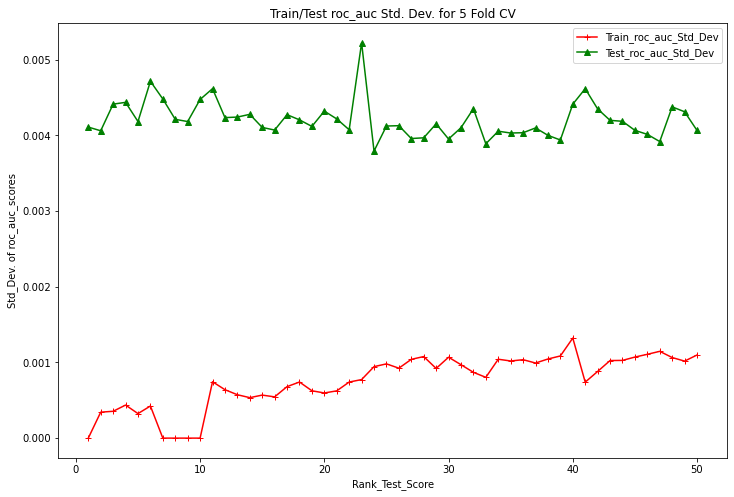

In [28]:
# Plotting the Standard Deviation of the Training & Test 5 fold roc_auc scores for the training dataset 
# vs rank_test_score obtained from Random Search CV.
plt.figure(figsize=(12,8))
plt.plot('rank_test_score', 'std_train_score', data=CV_Results, label='Train_roc_auc_Std_Dev', marker='+', color='r')
plt.plot('rank_test_score', 'std_test_score', data=CV_Results, label='Test_roc_auc_Std_Dev', marker='^', color='g')
plt.xlabel('Rank_Test_Score')
plt.ylabel('Std_Dev. of roc_auc_scores')
plt.title('Train/Test roc_auc Std. Dev. for 5 Fold CV')
plt.legend()
plt.show()

In [31]:
# Grouping by N_estimators to calculate variation of Training & Test set mean roc_auc score & their Std. Devs.
df_N_est = CV_Results.groupby('param_n_estimators',as_index=False)[['mean_test_score','mean_train_score','std_test_score','std_train_score']].mean()

In [32]:
df_N_est.head()

,param_n_estimators,mean_test_score,mean_train_score,std_test_score,std_train_score
0,100,0.748680,0.974420,0.004234,0.000640
1,160,0.739343,0.770576,0.004217,0.000625
2,170,0.707203,0.709368,0.004616,0.000740
3,190,0.706698,0.708926,0.004349,0.000881
4,280,0.741525,0.861533,0.004267,0.000597


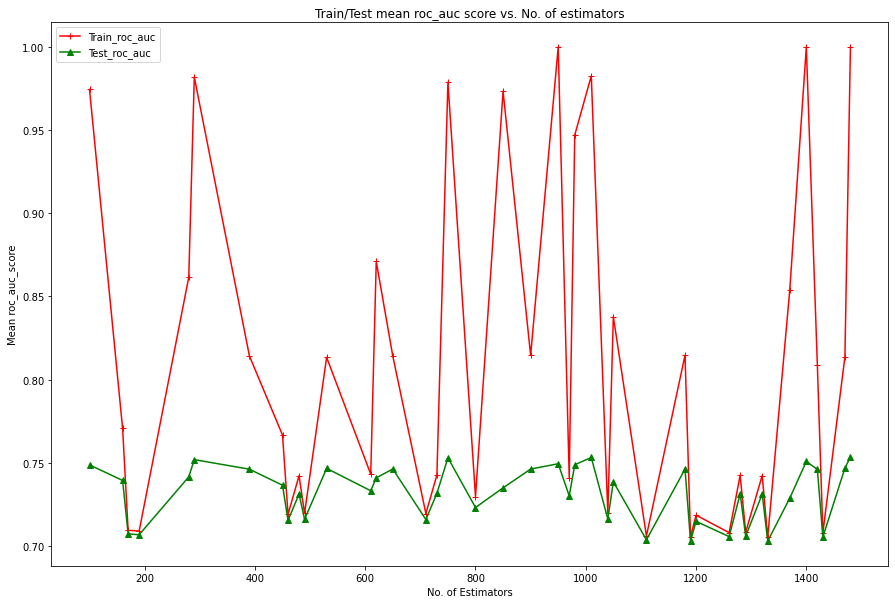

In [34]:
# Plotting the Training & Test 5 fold mean roc_auc scores vs No. of Estimators for the dataset.
plt.figure(figsize=(15,10))
plt.plot('param_n_estimators', 'mean_train_score', data=df_N_est, label='Train_roc_auc', marker='+', color='r')
plt.plot('param_n_estimators', 'mean_test_score', data=df_N_est, label='Test_roc_auc', marker='^',color='g')
plt.xlabel('No. of Estimators')
plt.ylabel('Mean roc_auc_score')
plt.title('Train/Test mean roc_auc score vs. No. of estimators')
plt.legend()
plt.show()

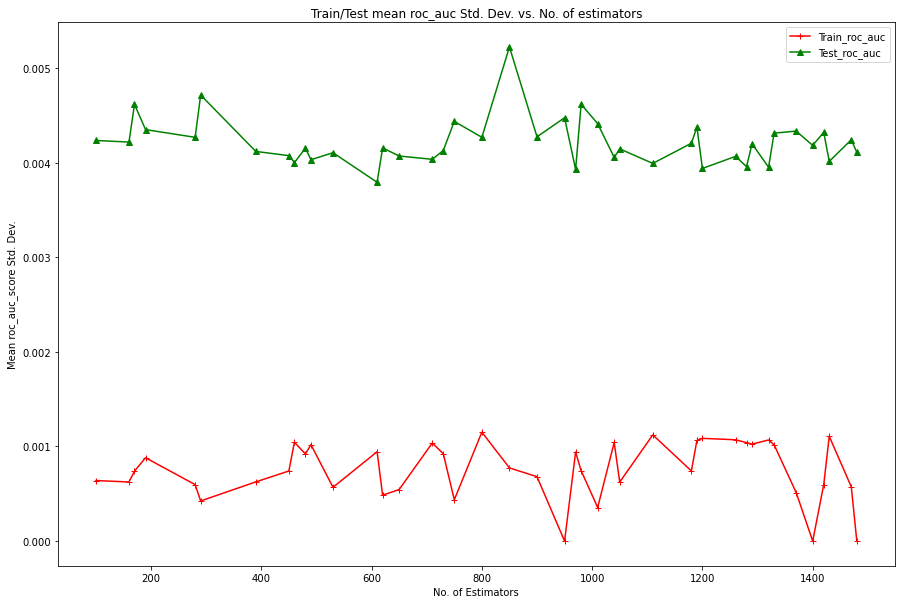

In [36]:
# Plotting the Training & Test 5 fold mean roc_auc scores Std_Dev. vs No. of Estimators for the dataset.
plt.figure(figsize=(15,10))
plt.plot('param_n_estimators', 'std_train_score', data=df_N_est, label='Train_roc_auc', marker='+', color='r')
plt.plot('param_n_estimators', 'std_test_score', data=df_N_est, label='Test_roc_auc', marker='^',color='g')
plt.xlabel('No. of Estimators')
plt.ylabel('Mean roc_auc_score Std. Dev.')
plt.title('Train/Test mean roc_auc Std. Dev. vs. No. of estimators')
plt.legend()
plt.show()

In [37]:
# Grouping by max_depths to calculate variation of Training & Test set mean roc_auc score & their Std. Devs.
df_max_depth = CV_Results.groupby('param_max_depth',as_index=False)[['mean_test_score','mean_train_score','std_test_score','std_train_score']].mean()

In [38]:
df_max_depth.head()

,param_max_depth,mean_test_score,mean_train_score,std_test_score,std_train_score
0,2,0.702757,0.705069,0.004250,0.001060
1,5,0.728863,0.739682,0.003888,0.000803
2,7,0.721589,0.737775,0.004211,0.000811
3,8,0.739343,0.770576,0.004217,0.000625
4,11,0.731683,0.742707,0.004123,0.000981


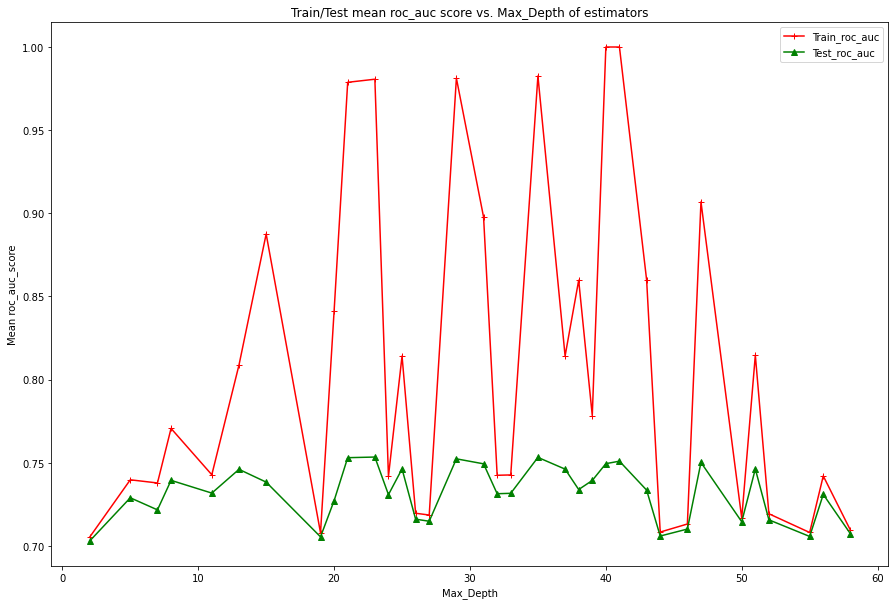

In [39]:
# Plotting the Training & Test 5 fold mean roc_auc scores vs Max_Depth of estimators for the dataset.
plt.figure(figsize=(15,10))
plt.plot('param_max_depth', 'mean_train_score', data=df_max_depth, label='Train_roc_auc', marker='+', color='r')
plt.plot('param_max_depth', 'mean_test_score', data=df_max_depth, label='Test_roc_auc', marker='^',color='g')
plt.xlabel('Max_Depth')
plt.ylabel('Mean roc_auc_score')
plt.title('Train/Test mean roc_auc score vs. Max_Depth of estimators')
plt.legend()
plt.show()

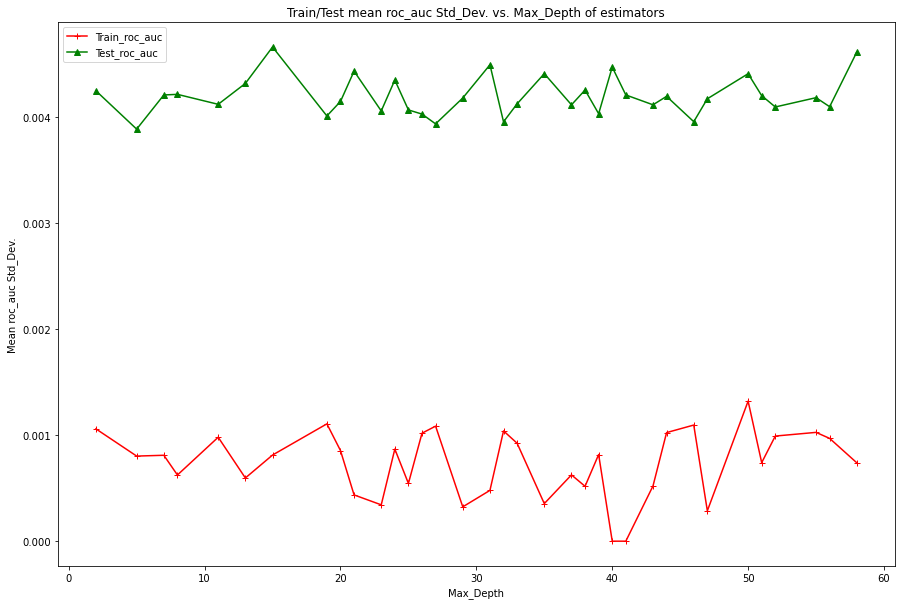

In [40]:
# Plotting the Training & Test 5 fold mean roc_auc scores Std_Dev. vs Max_Depth of estimators for the dataset.
plt.figure(figsize=(15,10))
plt.plot('param_max_depth', 'std_train_score', data=df_max_depth, label='Train_roc_auc', marker='+', color='r')
plt.plot('param_max_depth', 'std_test_score', data=df_max_depth, label='Test_roc_auc', marker='^',color='g')
plt.xlabel('Max_Depth')
plt.ylabel('Mean roc_auc Std_Dev.')
plt.title('Train/Test mean roc_auc Std_Dev. vs. Max_Depth of estimators')
plt.legend()
plt.show()

## Observations:
### 1) The training & test set roc_auc score for the best Random Forest classifier, obtained through Random Search CV are miles apart, indicating severe overfitting, which is typical of random forest classifiers. Thus this model can't be used for forecasting.
### 2) The aforementioned overfitting is also clearly evident in the previous graphs, with 5 fold mean roc_auc scores for training folds being consistently greater than those of test folds & mean roc_auc Std_Devs of training folds being consistently lesser than those of corresponding test folds.
### 3) Thus overfitting renders the above model useless, lets try tuning with optuna, a Bayesian hyperparameter tuner, which might give us a better model.

## Model_7: Random Forest Classifiers with Tuned Hyperparameters using Optuna.

In [41]:
# Importing  hyperparamater tuning optimizer optuna
import optuna

In [164]:
# Instantiating a new Random forest classifier
rf_o = RandomForestClassifier(n_jobs=5, random_state=42)

In [43]:
# Defining the appropriate objective function for the Random Forest classifier
def objective_wrappper_rf(X_tr, y_tr, cls=None, cv_strat=None, cl_w=None):
    '''
    Optimizes Random Forest parameters on the given training set X_tr, y_tr
    using cv_strat cross-validation & cl_w class weight objects.
    
    '''
    
    def objective(trial):
        params = {
        'max_depth': trial.suggest_categorical('max_depth',list(range(2,60))+ [None]),
        'n_estimators':trial.suggest_int('n_estimators',100,2000,10),
        'class_weight':trial.suggest_categorical('class_weight',cl_w),
        'min_samples_leaf':trial.suggest_loguniform('min_samples_leaf',.00001,.1)
          }
        
        cls.set_params(**params)#Initializing the model with the parameters 
    
        return np.mean(cross_val_score(cls, X_tr, y_tr, cv=cv_strat, n_jobs=5, scoring='roc_auc'))  
    return objective

In [44]:
# Defining the evaluation function for study's best parameters
def study_best_score_params(X_tr, y_tr, cls, obj_func, cv_strat, cl_w, n_trials=100):
    ''' Computes the best hyper parameters of the classsifier and returns 
    Optuna's study's best score & clasifier parameters'''
    study = optuna.create_study(direction='maximize')
    study.optimize(obj_func(X_tr, y_tr, cls, cv_strat, cl_w), n_trials)
    best_score = study.best_value
    best_params = study.best_params
    return (best_score,best_params)


#### Computing the best hyperparameters for the Random Forest Classifier_1 using Optuna.

In [45]:
# Extracting the best model parameters and best study score
best_study_score,best_study_params = study_best_score_params(X_train, y_train, rf_o, objective_wrappper_rf, cv_strat,
                                                            cl_weight, n_trials=50)

[I 2020-12-30 22:01:50,349] A new study created in memory with name: no-name-98b4ef3a-3a1b-4ecf-8de8-732f7f5bbd89
[I 2020-12-30 22:02:45,457] Trial 0 finished with value: 0.725423120316778 and parameters: {'max_depth': 56, 'n_estimators': 280, 'class_weight': {0: 1.0, 1: 12}, 'min_samples_leaf': 0.02096126296423985}. Best is trial 0 with value: 0.725423120316778.
[I 2020-12-30 22:09:10,157] Trial 1 finished with value: 0.7332735759549537 and parameters: {'max_depth': 6, 'n_estimators': 1680, 'class_weight': None, 'min_samples_leaf': 1.0045187833622311e-05}. Best is trial 1 with value: 0.7332735759549537.
[I 2020-12-30 22:09:37,192] Trial 2 finished with value: 0.7059665831773371 and parameters: {'max_depth': 2, 'n_estimators': 280, 'class_weight': 'balanced', 'min_samples_leaf': 1.9600645446629556e-05}. Best is trial 1 with value: 0.7332735759549537.
[I 2020-12-30 22:09:58,847] Trial 3 finished with value: 0.7130625192234248 and parameters: {'max_depth': 3, 'n_estimators': 170, 'class_

[I 2020-12-31 00:38:07,677] Trial 31 finished with value: 0.7508875803165 and parameters: {'max_depth': 19, 'n_estimators': 730, 'class_weight': 'balanced', 'min_samples_leaf': 5.9218711535559376e-05}. Best is trial 29 with value: 0.7538203772211709.
[I 2020-12-31 00:41:35,480] Trial 32 finished with value: 0.7450250360757111 and parameters: {'max_depth': 38, 'n_estimators': 370, 'class_weight': None, 'min_samples_leaf': 3.671812229848852e-05}. Best is trial 29 with value: 0.7538203772211709.
[I 2020-12-31 00:45:47,626] Trial 33 finished with value: 0.7523410284566404 and parameters: {'max_depth': 49, 'n_estimators': 480, 'class_weight': 'balanced', 'min_samples_leaf': 1.7548467052946596e-05}. Best is trial 29 with value: 0.7538203772211709.
[I 2020-12-31 00:48:02,315] Trial 34 finished with value: 0.7523345019587436 and parameters: {'max_depth': 48, 'n_estimators': 290, 'class_weight': 'balanced', 'min_samples_leaf': 0.00012477736291902577}. Best is trial 29 with value: 0.753820377221

In [46]:
print('The best roc_auc_score for the study is: ',best_study_score)

The best roc_auc_score for the study is:  0.7541648322752499


In [47]:
print('The best study parameters for the classifier are: ',best_study_params)

The best study parameters for the classifier are:  {'max_depth': 41, 'n_estimators': 1160, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 7.585412943078375e-05}


In [48]:
# Obtaining the best optuna tuned RF model by setting best study parameters.
rf_o = rf_o.set_params(**best_study_params)

In [49]:
# fitting the best optima tuned Random Forest model on the training set
rf_o.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 13}, max_depth=41,
                       min_samples_leaf=7.585412943078375e-05,
                       n_estimators=1160, n_jobs=5, random_state=42)

In [53]:
# Calculating the reduced feature training set roc_auc score using the best study parameters
cal_roc_auc(X_train, y_train, rf_o, 'reduced feature', 'training', 'Optuna tuned Random Forest Clasiifier')

The roc_auc_score for the reduced feature training set using the best Optuna tuned Random Forest Clasiifier is  0.9840878957953668


In [73]:
# Calculating the reduced feature test set roc_auc score using the best study parameters
cal_roc_auc(X_test, y_test, rf_o, 'reduced feature', 'test', 'Optuna tuned Random Forest Clasiifier')

The roc_auc_score for the reduced feature test set using the best Optuna tuned Random Forest Clasiifier is  0.7600334496125078


In [58]:
# Saving the best RF model tuned via Optuna
import joblib
joblib.dump(rf_o,'Rand_Forest_optuna_1.joblib')

['Rand_Forest_optuna_1.joblib']

### Calculating R_R ratio for best Random forest Classifier tuned through Optuna.

In [59]:
# Computing the CV scores using sklearn's cross_val_score
score_Rand_forest = cross_val_score(rf_o, X_train, y_train, cv=cv_strat, n_jobs=5, scoring='roc_auc')

In [60]:
print('The reward associated with the best optuna tuned Random Forest Classifier using roc_auc metric is: ',np.mean(score_Rand_forest))

The reward associated with the best optuna tuned Random Forest Classifier using roc_auc metric is:  0.7541648322752499


In [61]:
print('The risk associated with the best optuna tuned Random Forest Classifier using roc_auc metric is: ',np.std(score_Rand_forest))

The risk associated with the best optuna tuned Random Forest Classifier using roc_auc metric is:  0.00424937719463016


In [62]:
R_R_Ratio_Rand_forest = np.mean(score_Rand_forest)/np.std(score_Rand_forest)

In [63]:
print('The reward risk ratio for the best optuna tuned Random Forest Classifier using roc_auc metric is: ',R_R_Ratio_Rand_forest)

The reward risk ratio for the best optuna tuned Random Forest Classifier using roc_auc metric is:  177.47655661829


In [64]:
print('5 fold CV roc_auc scores for the optuna tuned Random Forest classifier are: ',score_Rand_forest)

5 fold CV roc_auc scores for the Random Forest classifier are:  [0.75036356 0.74880703 0.76041787 0.75699757 0.75423814]


#### R_R Ratio for the optuna tuned Random Forest classifier_1 using roc_auc metric is: 177.47655661829

## Observation(s):
### 1) The Optuna tuned Random Forest Classifier_1, rf_o,  is again severly overfitting , as can be viewed from the above results . Lets further try to reduce overfitting by incorporating more regularization.

In [65]:
# Instantiating a new Random forest classifier
rf_o_1 = RandomForestClassifier(n_jobs=5, random_state=42)

In [66]:
# Class weights for more regularized Rf classifier
cl_weight_reg = ['balanced',{0:1.0,1:12},{0:1.0,1:13},{0:1.0,1:14},{0:1.0,1:15},{0:1.0,1:16},
            {0:1.0,1:17}]

In [67]:
# Defining the appropriate objective function for more regularized Random Forest classifier
def objective_wrappper_rf_reg(X_tr, y_tr, cls=None, cv_strat=None, cl_w=None):
    '''
    Optimizes Random Forest parameters on the given training set X_tr,y_tr
    using cv_strat cross-validation  & cl_w class weight objects.
    
    '''
    
    def objective(trial):
        params = {
        'max_depth': trial.suggest_categorical('max_depth',list(range(2,35))),
        'n_estimators':trial.suggest_int('n_estimators',100,1200,10), # More regularization
        'class_weight':trial.suggest_categorical('class_weight',cl_w), # More Regularization
        'min_samples_leaf':trial.suggest_loguniform('min_samples_leaf',.0005,.1) # More Regularization
          }
        
        cls.set_params(**params)#Initializing the model with the parameters 
    
        return np.mean(cross_val_score(cls, X_tr, y_tr, cv=cv_strat, n_jobs=5, scoring='roc_auc'))  
    return objective

#### Computing the best hyperparameters for the Random Forest Classifier_2  using Optuna.

In [68]:
# Extracting the best model parameters and best study score
best_study_score,best_study_params = study_best_score_params(X_train, y_train, rf_o_1, objective_wrappper_rf_reg, cv_strat,
                                                            cl_weight_reg, n_trials=50)

[I 2020-12-31 03:33:10,958] A new study created in memory with name: no-name-104d2c47-bbbc-4dc2-86b4-151d97f5ef36
[I 2020-12-31 03:39:34,003] Trial 0 finished with value: 0.7448703589583614 and parameters: {'max_depth': 19, 'n_estimators': 1130, 'class_weight': 'balanced', 'min_samples_leaf': 0.0014868275641910663}. Best is trial 0 with value: 0.7448703589583614.
[I 2020-12-31 03:41:49,910] Trial 1 finished with value: 0.7157702182760699 and parameters: {'max_depth': 28, 'n_estimators': 1030, 'class_weight': 'balanced', 'min_samples_leaf': 0.05155741738991816}. Best is trial 0 with value: 0.7448703589583614.
[I 2020-12-31 03:42:27,233] Trial 2 finished with value: 0.7264948826222184 and parameters: {'max_depth': 5, 'n_estimators': 190, 'class_weight': {0: 1.0, 1: 17}, 'min_samples_leaf': 0.0015705319704820558}. Best is trial 0 with value: 0.7448703589583614.
[I 2020-12-31 03:43:49,946] Trial 3 finished with value: 0.7416874364649576 and parameters: {'max_depth': 13, 'n_estimators': 260

[I 2020-12-31 05:14:25,279] Trial 31 finished with value: 0.7462321267649864 and parameters: {'max_depth': 27, 'n_estimators': 720, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.0010022115128004443}. Best is trial 11 with value: 0.7464165932116549.
[I 2020-12-31 05:18:37,058] Trial 32 finished with value: 0.7448554307349707 and parameters: {'max_depth': 18, 'n_estimators': 740, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.001332319638362206}. Best is trial 11 with value: 0.7464165932116549.
[I 2020-12-31 05:22:04,036] Trial 33 finished with value: 0.742478293784837 and parameters: {'max_depth': 27, 'n_estimators': 650, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.00201872667460662}. Best is trial 11 with value: 0.7464165932116549.
[I 2020-12-31 05:26:20,733] Trial 34 finished with value: 0.7427909169102124 and parameters: {'max_depth': 10, 'n_estimators': 830, 'class_weight': 'balanced', 'min_samples_leaf': 0.0014846860707006977}. Best is trial 11 with valu

In [69]:
print('The best roc_auc_score for the study is: ',best_study_score)

The best roc_auc_score for the study is:  0.746517873003846


In [70]:
print('The best study parameters for the classifier are: ',best_study_params)

The best study parameters for the classifier are:  {'max_depth': 18, 'n_estimators': 570, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 0.0010028580411287713}


In [71]:
# Obtaining the best optuna tuned RF model by setting best study parameters.
rf_o_1 = rf_o_1.set_params(**best_study_params)

In [72]:
# fitting the best more regularized optima tuned Random Forest model on the training set
rf_o_1.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 13}, max_depth=18,
                       min_samples_leaf=0.0010028580411287713, n_estimators=570,
                       n_jobs=5, random_state=42)

In [76]:
# Calculating the reduced feature training set roc_auc score using the best study parameters
cal_roc_auc(X_train, y_train, rf_o_1, 'reduced feature', 'training', 'Optuna tuned more regularized Random Forest Clasiifier_2')

The roc_auc_score for the reduced feature training set using the best Optuna tuned more regualrized Random Forest Clasiifier_2 is  0.8019391919388983


In [77]:
# Calculating the reduced feature test set roc_auc score using the best study parameters
cal_roc_auc(X_test, y_test, rf_o_1, 'reduced feature', 'test', 'Optuna tuned more regularized Random Forest Clasiifier_2')

The roc_auc_score for the reduced feature test set using the best Optuna tuned more regularized Random Forest Clasiifier_2 is  0.7516519945423706


In [78]:
# Saving the best RF model tuned via Optuna
import joblib
joblib.dump(rf_o_1,'Rand_Forest_optuna_reg_2.joblib')

['Rand_Forest_optuna_reg_2.joblib']

### Calculating R_R ratio for regularized Random forest Classifier_2 tuned through Optuna.

In [79]:
# Computing the CV scores using sklearn's cross_val_score
score_Rand_forest_2 = cross_val_score(rf_o_1, X_train, y_train, cv=cv_strat, n_jobs=5, scoring='roc_auc')

In [80]:
print('The reward associated with the best regularized optuna tuned Random Forest Classifier_2 using roc_auc metric is: ',np.mean(score_Rand_forest_2))

The reward associated with the best regularized optuna tuned Random Forest Classifier_2 using roc_auc metric is:  0.746517873003846


In [81]:
print('The risk associated with the best regularized tuned Random Forest Classifier_2 using roc_auc metric is: ',np.std(score_Rand_forest_2))

The risk associated with the best regularized tuned Random Forest Classifier_2 using roc_auc metric is:  0.004273470245644585


In [82]:
R_R_Ratio_Rand_forest_2 = np.mean(score_Rand_forest_2)/np.std(score_Rand_forest_2)

In [83]:
print('The reward risk ratio for the best regularized optuna tuned Random Forest Classifier_2 using roc_auc metric is: ',R_R_Ratio_Rand_forest_2)

The reward risk ratio for the best regularized optuna tuned Random Forest Classifier using roc_auc metric is:  174.68657322808752


In [85]:
print('5 fold CV roc_auc scores for the optuna tuned regularized Random Forest classifier_2 are: ',score_Rand_forest_2)

5 fold CV roc_auc scores for the optuna tuned regularized Random Forest classifier_2 are:  [0.74198364 0.74169125 0.75295654 0.74890931 0.74704863]


#### R_R Ratio for the Random Forest classifier_2 using roc_auc metric is: 174.68657322808752

## Observation(s):
### 1) The regularized  Random Forest Classifier_2 , rf_o_1, has reduced the overfitting by an appreciable amount, but test set roc_auc score & R_R ratio have suffered a bit as a result.  Lets try to increase both by further tuning, while keeping the overfitting under control.

In [109]:
# Instantiating a new Random forest classifier
rf_o_2 = RandomForestClassifier(n_jobs=5, random_state=42)

In [110]:
# Class weights for new regularized Rf classifier
cl_weight_reg_2 = ['balanced',{0:1.0,1:12},{0:1.0,1:13},{0:1.0,1:14},{0:1.0,1:15},{0:1.0,1:16},
            {0:1.0,1:17},{0:1.0,1:18}]

In [111]:
# Defining the appropriate objective function for regularized Random Forest classifier
def objective_wrappper_rf_reg_2(X_tr, y_tr, cls=None, cv_strat=None, cl_w=None):
    '''
    Optimizes Random Forest parameters on the given training set X_tr,y_tr
    using cv_strat cross-validation & cl_w Class weights objects.
    
    '''
    
    def objective(trial):
        params = {
        'max_depth': trial.suggest_categorical('max_depth',list(range(2,35))),
        'n_estimators':trial.suggest_int('n_estimators',400,2000,10),
        'class_weight':trial.suggest_categorical('class_weight',cl_w),
        'min_samples_leaf':trial.suggest_loguniform('min_samples_leaf',.0005,.1)
          }
        
        cls.set_params(**params)#Initializing the model with the parameters 
    
        return np.mean(cross_val_score(cls, X_tr, y_tr, cv=cv_strat, n_jobs=5, scoring='roc_auc'))  
    return objective

#### Computing the best hyperparameters for the Random Forest Classifier_3 using Optuna.

In [112]:
# Extracting the best model parameters and best study score
best_study_score,best_study_params = study_best_score_params(X_train, y_train, rf_o_2, objective_wrappper_rf_reg_2, cv_strat,
                                                            cl_weight_reg_2, n_trials=50)

[I 2020-12-31 19:13:45,444] A new study created in memory with name: no-name-12dad54c-2996-475f-9673-4642768e7e61
[I 2020-12-31 19:16:52,701] Trial 0 finished with value: 0.7142128341936669 and parameters: {'max_depth': 3, 'n_estimators': 1510, 'class_weight': 'balanced', 'min_samples_leaf': 0.0022116932852386285}. Best is trial 0 with value: 0.7142128341936669.
[I 2020-12-31 19:19:19,360] Trial 1 finished with value: 0.7379824094389383 and parameters: {'max_depth': 11, 'n_estimators': 530, 'class_weight': {0: 1.0, 1: 14}, 'min_samples_leaf': 0.004124759942579928}. Best is trial 1 with value: 0.7379824094389383.
[I 2020-12-31 19:24:51,001] Trial 2 finished with value: 0.746881681967061 and parameters: {'max_depth': 24, 'n_estimators': 920, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.0008873372493785122}. Best is trial 2 with value: 0.746881681967061.
[I 2020-12-31 19:27:56,832] Trial 3 finished with value: 0.7073230428092312 and parameters: {'max_depth': 16, 'n_estimators': 

[I 2020-12-31 21:37:09,085] Trial 30 finished with value: 0.7407088679798781 and parameters: {'max_depth': 14, 'n_estimators': 2000, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 0.00287538690771354}. Best is trial 25 with value: 0.7494801102730937.
[I 2020-12-31 21:42:16,550] Trial 31 finished with value: 0.7492618713490031 and parameters: {'max_depth': 32, 'n_estimators': 780, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 0.0005155552287417162}. Best is trial 25 with value: 0.7494801102730937.
[I 2020-12-31 21:45:52,128] Trial 32 finished with value: 0.7480922140390531 and parameters: {'max_depth': 32, 'n_estimators': 570, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 0.0007209517753660815}. Best is trial 25 with value: 0.7494801102730937.
[I 2020-12-31 21:50:20,535] Trial 33 finished with value: 0.746269515018205 and parameters: {'max_depth': 23, 'n_estimators': 760, 'class_weight': {0: 1.0, 1: 14}, 'min_samples_leaf': 0.0010326402159462123}. Best is trial 25 wi

In [113]:
print('The best roc_auc_score for the study is: ',best_study_score)

The best roc_auc_score for the study is:  0.749553463129595


In [114]:
print('The best study parameters for the classifier are: ',best_study_params)

The best study parameters for the classifier are:  {'max_depth': 21, 'n_estimators': 1440, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 0.0005109567637031831}


In [115]:
# Obtaining the best optuna tuned RF model by setting best study parameters.
rf_o_2 = rf_o_2.set_params(**best_study_params)

In [116]:
# fitting the best regularized optima tuned Random Forest_3 model on the training set
rf_o_2.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 13}, max_depth=21,
                       min_samples_leaf=0.0005109567637031831,
                       n_estimators=1440, n_jobs=5, random_state=42)

In [117]:
# Calculating the reduced feature training set roc_auc score using the best study parameters
cal_roc_auc(X_train, y_train, rf_o_2, 'reduced feature', 'training', 'Optuna tuned more regularized Random Forest Clasiifier_3')

The roc_auc_score for the reduced feature training set using the best Optuna tuned more regularized Random Forest Clasiifier_3 is  0.8429386882500551


In [118]:
# Calculating the reduced feature test set roc_auc score using the best study parameters
cal_roc_auc(X_test, y_test, rf_o_2, 'reduced feature', 'test', 'Optuna tuned more regularized Random Forest Clasiifier_3')

The roc_auc_score for the reduced feature test set using the best Optuna tuned more regularized Random Forest Clasiifier_3 is  0.7548292754366334


### Calculating R_R ratio for regularized Random forest Classifier_3 tuned through Optuna.

In [119]:
# Computing the CV scores using sklearn's cross_val_score
score_Rand_forest_3 = cross_val_score(rf_o_2, X_train, y_train, cv=cv_strat, n_jobs=5, scoring='roc_auc')

In [120]:
print('The reward associated with the best regularized optuna tuned Random Forest Classifier_3 using roc_auc metric is: ',np.mean(score_Rand_forest_3))

The reward associated with the best regularized optuna tuned Random Forest Classifier_3 using roc_auc metric is:  0.749553463129595


In [121]:
print('The risk associated with the best regularized tuned Random Forest Classifier_3 using roc_auc metric is: ',np.std(score_Rand_forest_3))

The risk associated with the best regularized tuned Random Forest Classifier_3 using roc_auc metric is:  0.004400353555007669


In [122]:
R_R_Ratio_Rand_forest_3 = np.mean(score_Rand_forest_3)/np.std(score_Rand_forest_3)

In [123]:
print('The reward risk ratio for the best regularized optuna tuned Random Forest Classifier_3 using roc_auc metric is: ',R_R_Ratio_Rand_forest_3)

The reward risk ratio for the best regularized optuna tuned Random Forest Classifier_3 using roc_auc metric is:  170.3393724526048


In [124]:
print('5 fold CV roc_auc scores for the optuna tuned regularized Random Forest classifier_3 are: ',score_Rand_forest_3)

5 fold CV roc_auc scores for the optuna tuned regularized Random Forest classifier_3 are:  [0.74523614 0.74426064 0.75623491 0.75180266 0.75023296]


In [125]:
# Saving the best RF model tuned via Optuna
import joblib
joblib.dump(rf_o_2,'Rand_Forest_optuna_reg_3.joblib')

['Rand_Forest_optuna_reg_3.joblib']

#### R_R Ratio for the Random Forest classifier_3 using roc_auc metric is: 170.3393724526048

## Observation(s):
### 1) The previous Random Forest Classifier_3, rf_o_2 , has raised the test set roc_auc score at the cost of increased overfitting & reduced R_R ratio. 
### 2) Taking all the factors into consideration, Random Forest Classifier_2  has given the best results among all the Random Forest Classifiers variants.

## Model_8: Extra Trees Classifiers with Tuned Hyperparameters using Optuna.

In [126]:
# Defining the appropriate objective function for the Extra Trees classifier
def objective_wrappper_ext(X_tr, y_tr, cls=None, cv_strat=None, cl_w=None):
    '''
    Optimizes Extra Trees parameters on the given training set X_tr,y_tr
    using cross-validation cv_strat & cl_w class weight objects.
    
    '''
    
    def objective(trial):
        params = {
        'max_depth': trial.suggest_categorical('max_depth',list(range(2,50))+ [None]),
        'n_estimators':trial.suggest_int('n_estimators',100,2000,10),
        'class_weight':trial.suggest_categorical('class_weight',cl_w),
        'min_samples_leaf':trial.suggest_loguniform('min_samples_leaf',.00001,.1)
          }
        
        cls.set_params(**params)#Initializing the model with the parameters 
    
        return np.mean(cross_val_score(cls, X_tr, y_tr, cv=cv_strat, n_jobs=5, scoring='roc_auc'))  
    return objective

In [127]:
# Importing Extra Trees Classifier from  Sklearn
from sklearn.ensemble import ExtraTreesClassifier

In [128]:
# Instantiating the Extra Trees classifier
ext_s = ExtraTreesClassifier(n_jobs=5,random_state=42)

#### Computing the best hyperparameters for the Extra Trees Classifier using Optuna.

In [129]:
# Extracting the best model parameters and best study score
best_study_score,best_study_params = study_best_score_params(X_train, y_train, ext_s, objective_wrappper_ext, cv_strat,
                                                            cl_weight, n_trials=50)

[I 2021-01-01 00:41:42,581] A new study created in memory with name: no-name-3ca351aa-1aa4-46dc-883f-a329a9c6eda8
[I 2021-01-01 00:56:36,892] Trial 0 finished with value: 0.7459640640962669 and parameters: {'max_depth': 24, 'n_estimators': 1770, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 4.5201780535857576e-05}. Best is trial 0 with value: 0.7459640640962669.
[I 2021-01-01 01:00:10,788] Trial 1 finished with value: 0.7455353538868094 and parameters: {'max_depth': 33, 'n_estimators': 390, 'class_weight': 'balanced', 'min_samples_leaf': 1.4001991807674805e-05}. Best is trial 0 with value: 0.7459640640962669.
[I 2021-01-01 01:07:57,313] Trial 2 finished with value: 0.7333643746780969 and parameters: {'max_depth': 23, 'n_estimators': 890, 'class_weight': 'balanced', 'min_samples_leaf': 1.5095259318685542e-05}. Best is trial 0 with value: 0.7459640640962669.
[I 2021-01-01 01:21:11,773] Trial 3 finished with value: 0.7469263738902048 and parameters: {'max_depth': 28, 'n_estimators'

[I 2021-01-01 05:30:14,650] Trial 30 finished with value: 0.7471847686546262 and parameters: {'max_depth': 27, 'n_estimators': 1770, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 5.2957861034337425e-05}. Best is trial 26 with value: 0.7475053269889405.
[I 2021-01-01 05:44:44,159] Trial 31 finished with value: 0.7473917190417219 and parameters: {'max_depth': 27, 'n_estimators': 1720, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 4.7817948264639086e-05}. Best is trial 26 with value: 0.7475053269889405.
[I 2021-01-01 05:59:43,581] Trial 32 finished with value: 0.7473816388512617 and parameters: {'max_depth': 27, 'n_estimators': 1780, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 4.638816363162191e-05}. Best is trial 26 with value: 0.7475053269889405.
[I 2021-01-01 06:16:32,604] Trial 33 finished with value: 0.7437393312423033 and parameters: {'max_depth': 27, 'n_estimators': 1910, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 2.1476372118563715e-05}. Best is tr

In [130]:
print('The best roc_auc_score for the study is: ',best_study_score)

The best roc_auc_score for the study is:  0.7487431721429978


In [131]:
print('The best study parameters for the classifier are: ', best_study_params)

The best study parameters for the classifier are:  {'max_depth': 46, 'n_estimators': 2000, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 1.7075630910980877e-05}


In [132]:
# Obtaining the best reduced feature Extra Trees model by setting tuned best study parameters.
extr_s = ext_s.set_params(**best_study_params)

In [133]:
# fitting the best tuned Extra Trees model on the reduced feature training set
extr_s.fit(X_train, y_train)

ExtraTreesClassifier(class_weight={0: 1.0, 1: 15}, max_depth=46,
                     min_samples_leaf=1.7075630910980877e-05, n_estimators=2000,
                     n_jobs=5, random_state=42)

In [136]:
# Calculating the reduced feature training set roc_auc score using the tuned best study parameters
cal_roc_auc(X_train, y_train, extr_s, 'reduced feature', 'training', 'tuned Extra Trees Classifier')

The roc_auc_score for the reduced feature training set using the best tuned Extra Trees Classifier is  1.0


In [137]:
# Calculating the reduced feature test set roc_auc score using the tuned best study parameters
cal_roc_auc(X_test, y_test, extr_s, 'reduced feature', 'test', 'tuned Extra Trees Classifier')

The roc_auc_score for the reduced feature test set using the best tuned Extra Trees Classifier is  0.7545603594015475


### Calculating R_R ratio for Extra Trees Classifier tuned through Optuna.

In [138]:
# Computing the CV scores using sklearn's cross_val_score
score_Extra_Trees = cross_val_score(extr_s, X_train, y_train, cv=cv_strat, n_jobs=5, scoring='roc_auc')

In [139]:
print('The reward associated with the best tuned Extra Trees Classifier using roc_auc metric is: ',np.mean(score_Extra_Trees))

The reward associated with the best tuned Extra Trees Classifier using roc_auc metric is:  0.7487431721429978


In [140]:
print('The risk associated with the best Extra Trees Classifier using roc_auc metric is: ',np.std(score_Extra_Trees))

The risk associated with the best Extra Trees Classifier using roc_auc metric is:  0.003743057844125743


In [141]:
R_R_Ratio_Extra_Trees = np.mean(score_Extra_Trees)/np.std(score_Extra_Trees)

In [142]:
print('The reward risk ratio for the best Extra trees Classifier using roc_auc metric is: ',R_R_Ratio_Extra_Trees)

The reward risk ratio for the best Extra trees Classifier using roc_auc metric is:  200.0351593064627


In [157]:
print('5 fold CV roc_auc scores for the optuna tuned Extra Trees classifier are: ',score_Extra_Trees)

5 fold CV roc_auc scores for the optuna tuned Extra Trees classifier are:  [0.7438268  0.74759777 0.7552674  0.74948591 0.74753798]


In [144]:
# Saving the Optuna tuned Extra Trees Classifier  
joblib.dump(extr_s,'Extra_Trees.joblib')

['Extra_Trees.joblib']

#### R_R Ratio for the Extra Trees classifier_1 using roc_auc metric is: 200.0351593064627

## Observation(s):
### 1) The Optuna tuned Extra Trees Classifier, extr_s, is  severely overfitting , as can be viewed from the above results . However , typical of an Extra Trees Classifier,  its R_R ratio is the highest we have seen so far of any classifier.  

#### Lets try to reduce overfitting by incorporating more regularization & tuning another Extra Trees Classifier_1

In [145]:
# Instantiating a new Extra Trees classifier
ext_s_reg = ExtraTreesClassifier(n_jobs=5,random_state=42)

In [148]:
# Defining the appropriate objective function for more regularized Extra Trees classifier
def objective_wrappper_ext_reg(X_tr, y_tr, cls=None, cv_strat=None, cl_w=None):
    '''
    Optimizes Extra Trees parameters on the given training set X_tr,y_tr
    using cv_strat cross-validation & cl_w class weight objects.
    
    '''
    
    def objective(trial):
        params = {
        'max_depth': trial.suggest_categorical('max_depth',list(range(2,35))),# More Regularization
        'n_estimators':trial.suggest_int('n_estimators',500,1500,10),# More Regularization
        'class_weight':trial.suggest_categorical('class_weight',cl_w),
        'min_samples_leaf':trial.suggest_loguniform('min_samples_leaf',.0005,.1)# More Regularization
          }
        
        cls.set_params(**params)#Initializing the model with the parameters 
    
        return np.mean(cross_val_score(cls, X_tr, y_tr, cv=cv_strat, n_jobs=5, scoring='roc_auc'))  
    return objective

#### Computing the best hyperparameters for the regularized Extra Trees Classifier using Optuna.

In [149]:
# Extracting the best model parameters and best study score
best_study_score,best_study_params = study_best_score_params(X_train, y_train, ext_s_reg, objective_wrappper_ext_reg, cv_strat,
                                                            cl_weight_reg, n_trials=50)

[I 2021-01-01 19:04:42,883] A new study created in memory with name: no-name-289e43cb-2e3b-46e8-810b-dcc43391be30
[I 2021-01-01 19:06:07,805] Trial 0 finished with value: 0.7243081480957138 and parameters: {'max_depth': 5, 'n_estimators': 540, 'class_weight': 'balanced', 'min_samples_leaf': 0.005005463296305543}. Best is trial 0 with value: 0.7243081480957138.
[I 2021-01-01 19:11:10,884] Trial 1 finished with value: 0.7289954039459501 and parameters: {'max_depth': 20, 'n_estimators': 1260, 'class_weight': {0: 1.0, 1: 14}, 'min_samples_leaf': 0.00782709643214022}. Best is trial 1 with value: 0.7289954039459501.
[I 2021-01-01 19:20:57,942] Trial 2 finished with value: 0.7415913311378238 and parameters: {'max_depth': 24, 'n_estimators': 1500, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.0005515213337460888}. Best is trial 2 with value: 0.7415913311378238.
[I 2021-01-01 19:24:46,477] Trial 3 finished with value: 0.7230107944553851 and parameters: {'max_depth': 17, 'n_estimators':

[I 2021-01-01 22:08:08,771] Trial 30 finished with value: 0.7264877295945456 and parameters: {'max_depth': 9, 'n_estimators': 1250, 'class_weight': 'balanced', 'min_samples_leaf': 0.010892911359690985}. Best is trial 11 with value: 0.7417565940944973.
[I 2021-01-01 22:15:55,820] Trial 31 finished with value: 0.7391383265853111 and parameters: {'max_depth': 13, 'n_estimators': 1360, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.0005473950281549241}. Best is trial 11 with value: 0.7417565940944973.
[I 2021-01-01 22:23:25,638] Trial 32 finished with value: 0.7368095191941213 and parameters: {'max_depth': 31, 'n_estimators': 1400, 'class_weight': {0: 1.0, 1: 14}, 'min_samples_leaf': 0.0018083198815433464}. Best is trial 11 with value: 0.7417565940944973.
[I 2021-01-01 22:32:18,574] Trial 33 finished with value: 0.7393314490515224 and parameters: {'max_depth': 27, 'n_estimators': 1500, 'class_weight': {0: 1.0, 1: 15}, 'min_samples_leaf': 0.0010093811588794484}. Best is trial 11 wit

In [150]:
print('The best roc_auc_score for the study is: ',best_study_score)

The best roc_auc_score for the study is:  0.7417691046915931


In [151]:
print('The best study parameters for the classifier are: ', best_study_params)

The best study parameters for the classifier are:  {'max_depth': 29, 'n_estimators': 1440, 'class_weight': {0: 1.0, 1: 13}, 'min_samples_leaf': 0.0005035858131451156}


In [152]:
# Obtaining the best regularized Extra Trees model by setting tuned best study parameters.
ext_s_reg = ext_s_reg.set_params(**best_study_params)

In [153]:
# fitting the best regularized Extra Trees model on the reduced feature training set
ext_s_reg.fit(X_train, y_train)

ExtraTreesClassifier(class_weight={0: 1.0, 1: 13}, max_depth=29,
                     min_samples_leaf=0.0005035858131451156, n_estimators=1440,
                     n_jobs=5, random_state=42)

In [154]:
# Calculating the reduced feature training set roc_auc score using the tuned best study parameters
cal_roc_auc(X_train, y_train, ext_s_reg, 'reduced feature', 'training', 'regularized Extra Trees Classifier')

The roc_auc_score for the reduced feature training set using the best regularized Extra Trees Classifier is  0.8048057417779043


In [155]:
# Calculating the reduced feature test set roc_auc score using the tuned best study parameters
cal_roc_auc(X_test, y_test, ext_s_reg, 'reduced feature', 'test', 'regularized Extra Trees Classifier')

The roc_auc_score for the reduced feature test set using the best regularized Extra Trees Classifier is  0.7463489011999241


### Calculating R_R ratio for regularized Extra Trees Classifier_1 tuned through Optuna.

In [156]:
# Computing the CV scores using sklearn's cross_val_score
score_Extra_Trees_1 = cross_val_score(ext_s_reg, X_train, y_train, cv=cv_strat, n_jobs=5, scoring='roc_auc')

In [158]:
print('The reward associated with the best regularized Extra Trees Classifier_1 using roc_auc metric is: ',np.mean(score_Extra_Trees_1))

The reward associated with the best regularized Extra Trees Classifier_1 using roc_auc metric is:  0.7417691046915931


In [159]:
print('The risk associated with the best regularized Extra Trees Classifier using roc_auc metric is: ',np.std(score_Extra_Trees_1))

The risk associated with the best regularized Extra Trees Classifier using roc_auc metric is:  0.003826060533215682


In [160]:
R_R_Ratio_Extra_Trees_1 = np.mean(score_Extra_Trees_1)/np.std(score_Extra_Trees_1)

In [161]:
print('The reward risk ratio for the best regularized Extra trees Classifier_1 using roc_auc metric is: ',R_R_Ratio_Extra_Trees_1)

The reward risk ratio for the best regularized Extra trees Classifier_1 using roc_auc metric is:  193.8728094477271


In [162]:
print('5 fold CV roc_auc scores for the optuna tuned Extra Trees classifier_1 are: ',score_Extra_Trees_1)

5 fold CV roc_auc scores for the optuna tuned Extra Trees classifier_1 are:  [0.73650949 0.74095577 0.74844313 0.74173813 0.74119901]


In [163]:
# Saving the Optuna tuned regularized Extra Trees Classifier  
joblib.dump(ext_s_reg,'Extra_Trees_Regularized.joblib')

['Extra_Trees_Regularized.joblib']

#### R_R Ratio for the regularized Extra Trees classifier_1 using roc_auc metric is: 193.8728094477271

## Observation(s):
### 1) As observed above, the Extra Trees classifier_1 has substantially reduced the overfitting , but the test set roc_auc score as well as the R_R ratio has also taken a beating.
### 2) The Extra Trees Classifier_1 is making use of high number of estimators to achieve scores comparable to the best Random Forest Classifier, viz.  Random forest classifier_2, resulting in a more computationally expensive model.


### Taking everything into consideration, viz. Overfitting, test set roc_auc score, R_R ratios & Computational costs, the best tree based bagging classifier is Random Forest classifier_2.

### R_R Ratio for the best Tree based bagging classifier using roc_auc score is:  200.0351593064627,  corresponding to Tuned Extra Trees classifier.